In [19]:
#Library imports
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

## Heart 2022

### Exploratory Data Analysis
### todo for eda

Counts of cardiovascular events
HadHeartDisease
Missing values

How compilation benefits us (frequency)
Frequency of yes and no for 0 and 1 cardiovascular event 
Frequency table
Increased frequency of those with cardiovascular
Work with larger population 

Correlating impairments to age
Vertical scatterplot (x-axis as variables/y-axis as age — use `hue = age` to group the points → introduce noise so that the points are more separated 

In [20]:
heart_d = pd.read_csv('../../Data/heart_2022_with_nans.csv')

In [21]:
heart_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

In [22]:
# check missing in column 
heart_d.isnull().sum().sort_values()

State                            0
Sex                              0
HadDiabetes                   1087
PhysicalActivities            1093
GeneralHealth                 1198
HadStroke                     1557
HadAsthma                     1773
HadKidneyDisease              1926
HadCOPD                       2219
HadArthritis                  2633
HadDepressiveDisorder         2812
HadHeartAttack                3065
HadSkinCancer                 3143
HadAngina                     4405
SleepHours                    5453
LastCheckupTime               8308
MentalHealthDays              9067
AgeCategory                   9079
PhysicalHealthDays           10927
RemovedTeeth                 11360
RaceEthnicityCategory        14057
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyDressingBathing    23915
DifficultyWalking            24012
DifficultyConcentrating      24240
DifficultyErrands            25656
HeightInMeters               28652
SmokerStatus        

In [23]:
# create a new column to indicate if the patient had any of heart diseases
heart_d['HadHeartDisease'] = heart_d.apply(lambda row: 'Yes' if 'Yes' in [row['HadHeartAttack'], 
                                                                          row['HadStroke'], 
                                                                          row['HadAngina']] else 'No', 
                                                                          axis=1)

*Note: even if the other three values have NAs, 'No' will be assigned to `HadHeartDisease`*

In [24]:
print(pd.crosstab(index = heart_d['HadHeartAttack'],columns = heart_d['HadStroke']))
print("=============================")
print(pd.crosstab(index = heart_d['HadHeartAttack'],columns = heart_d['HadAngina']))
print("=============================")
print(pd.crosstab(index = heart_d['HadStroke'],columns = heart_d['HadAngina']))


HadStroke           No    Yes
HadHeartAttack               
No              402131  13960
Yes              19970   4936
HadAngina           No    Yes
HadHeartAttack               
No              400360  14240
Yes              11971  11908
HadAngina      No    Yes
HadStroke               
No         399041  22006
Yes         14233   4366


In [25]:
# perform chi-square on three heart diseases columns 
chi2, p, dof, ex = chi2_contingency(pd.crosstab(heart_d['HadHeartAttack'], heart_d['HadStroke']))
print(f'Chi-square test for HadHeartAttack and HadStroke: p-value = {p}')
chi2, p, dof, ex = chi2_contingency(pd.crosstab(heart_d['HadHeartAttack'], heart_d['HadAngina']))
print(f'Chi-square test for HadHeartAttack and HadAngina: p-value = {p}')
chi2, p, dof, ex = chi2_contingency(pd.crosstab(heart_d['HadStroke'], heart_d['HadAngina']))
print(f'Chi-square test for HadStroke and HadAngina: p-value = {p}')


Chi-square test for HadHeartAttack and HadStroke: p-value = 0.0
Chi-square test for HadHeartAttack and HadAngina: p-value = 0.0
Chi-square test for HadStroke and HadAngina: p-value = 0.0


In [26]:
heart_d['Sex'].value_counts()

Female    235893
Male      209239
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Correlation Heatmap on numeric data')

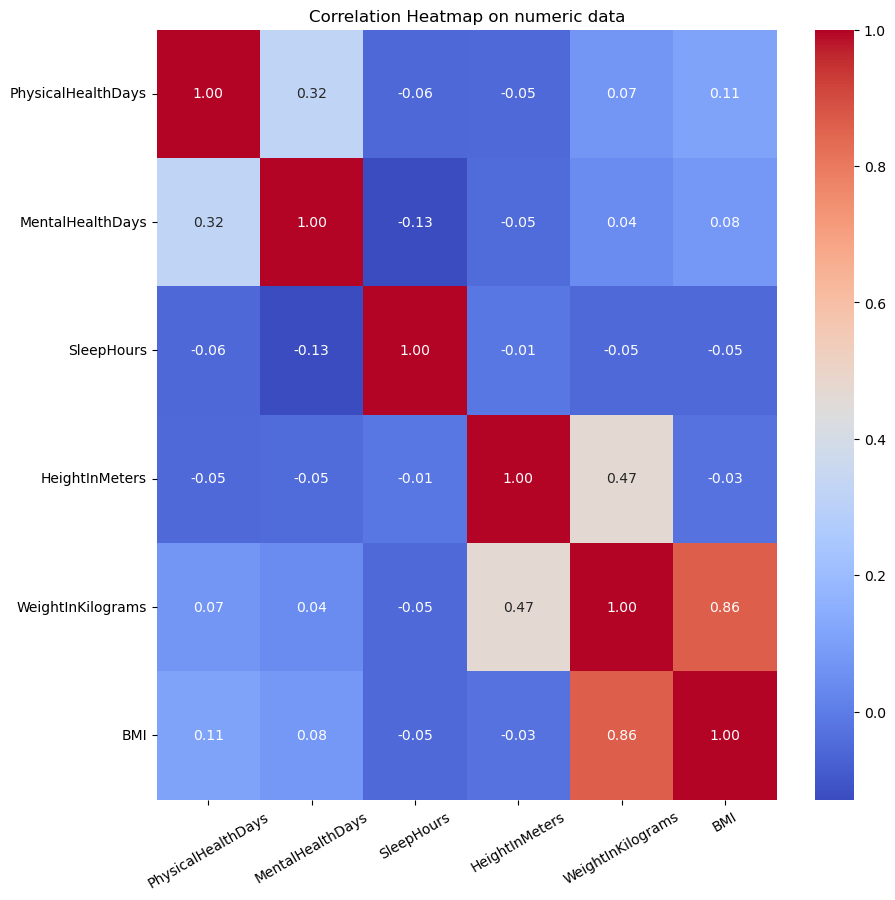

In [27]:
# correlation of the numerics
plt.figure(figsize=(10,10))
sns.heatmap(heart_d.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
# tilt the x-axis labels
plt.xticks(rotation = 30)
plt.title("Correlation Heatmap on numeric data")
#plt.savefig('../../Figures/heatmap.png')

In [28]:
# tabulate the proportion of patients with heart diseases
heart_d['HadHeartDisease'].value_counts(normalize = True).round(2)

No     0.88
Yes    0.12
Name: HadHeartDisease, dtype: float64

Text(0.5, 1.0, 'Proportion of patients with heart diseases')

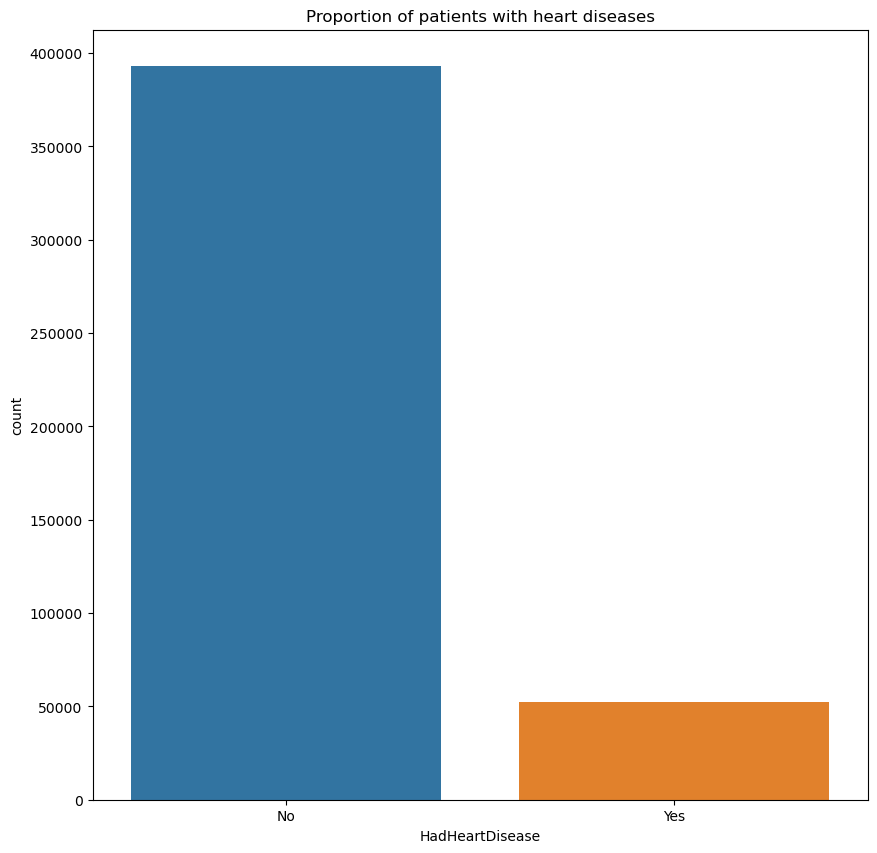

In [29]:
# proportion of patients with heart diseases
plt.figure(figsize=(10,10))
sns.countplot(x = 'HadHeartDisease', data = heart_d)
plt.title("Proportion of patients with heart diseases")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

IndexError: index 5 is out of bounds for axis 0 with size 5

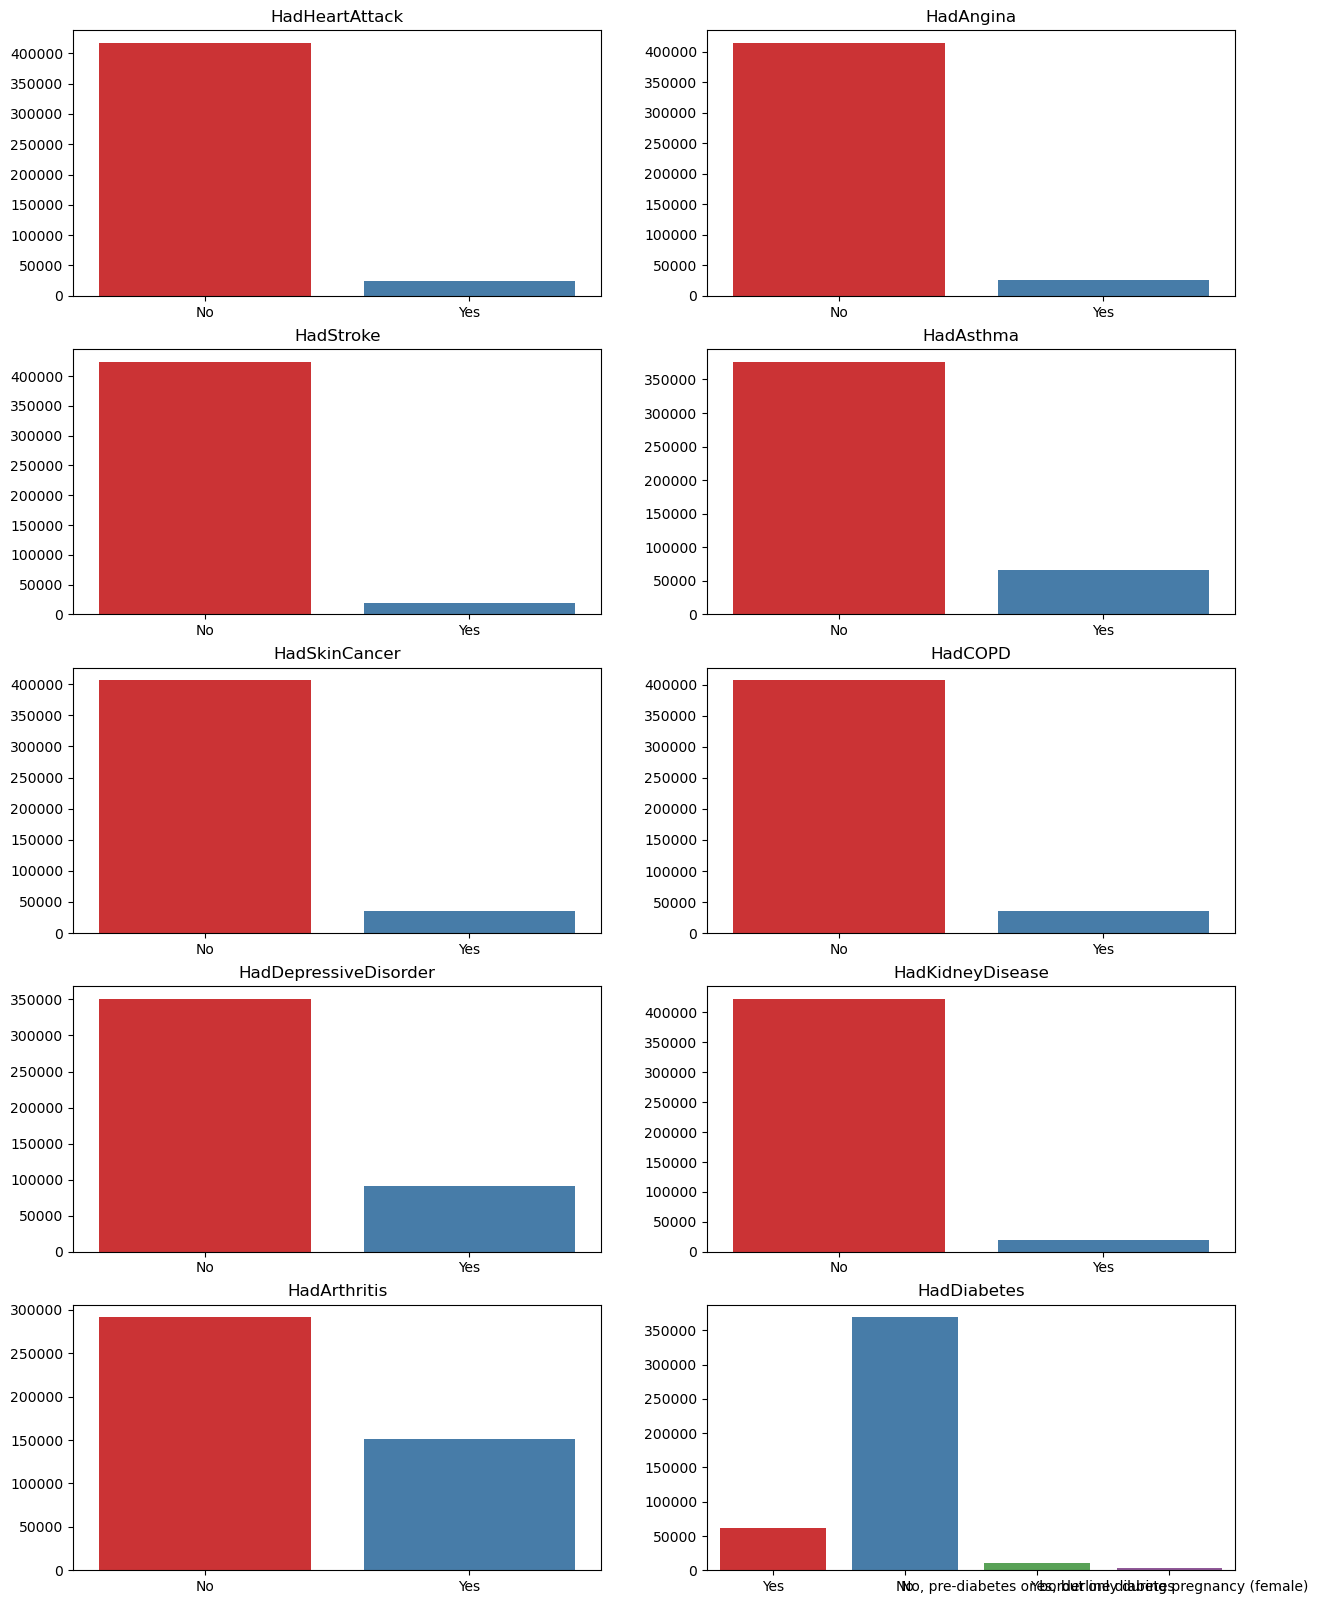

In [30]:
# get all columns that start with "had"
had_cols = [col for col in heart_d.columns if 'Had' in col]

# plot the count plot above with a for loop
fig, axes = plt.subplots(nrows = 5, ncols = 2)
fig.set_size_inches(15,20)

for i, col in enumerate(had_cols):
    sns.countplot(heart_d[col], ax = axes[i//2, i%2], 
                  palette = 'Set1')
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('')
    axes[i//2, i%2].set_ylabel('')
plt.tight_layout()

#### Correlating impairments to age

In [ ]:
impairment = [col for col in heart_d.columns if 'Difficulty' in col]
# add one more columns to the list
impairment.extend(['DealORHardOfHearing'])

Text(0.5, 1.0, 'Count of AgeCategory')

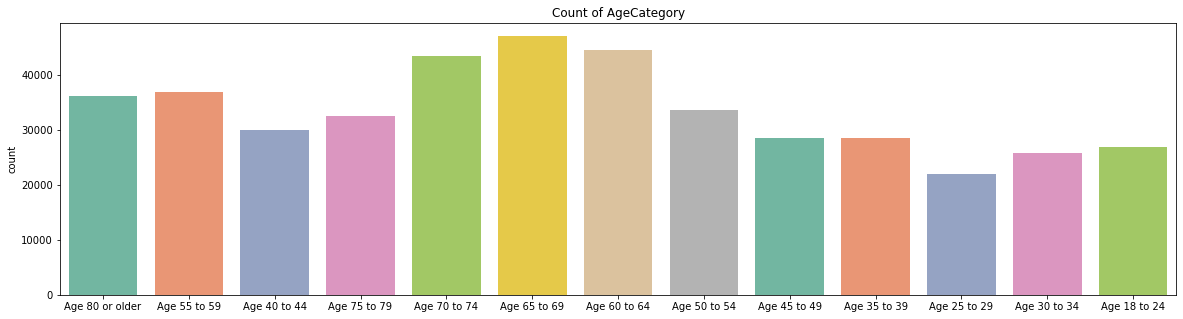

In [ ]:
# see proportion for AgeCategory
plt.figure(figsize=(20,5))
sns.countplot(heart_d['AgeCategory'], palette = 'Set2')
plt.xlabel('')
plt.title('Count of AgeCategory')

### Missing value imputation

In [72]:
heart_d = pd.read_csv('../../Data/heart_2022_with_nans.csv')

In [73]:
# check missing in column 
heart_d.isnull().sum().sort_values()

State                            0
Sex                              0
HadDiabetes                   1087
PhysicalActivities            1093
GeneralHealth                 1198
HadStroke                     1557
HadAsthma                     1773
HadKidneyDisease              1926
HadCOPD                       2219
HadArthritis                  2633
HadDepressiveDisorder         2812
HadHeartAttack                3065
HadSkinCancer                 3143
HadAngina                     4405
SleepHours                    5453
LastCheckupTime               8308
MentalHealthDays              9067
AgeCategory                   9079
PhysicalHealthDays           10927
RemovedTeeth                 11360
RaceEthnicityCategory        14057
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyDressingBathing    23915
DifficultyWalking            24012
DifficultyConcentrating      24240
DifficultyErrands            25656
HeightInMeters               28652
SmokerStatus        

#### Dropping rows with missing values

Experiment with differeng thresholds

In [74]:
# calculate number of NAs per row
na_count_per_row = heart_d.isna().sum(axis=1)

#loop through a range of thresholds (3 ~ half of the columns)
# Drop rows where the number of NAs is greater than a certain number of columns
for threshold in range(3, int(heart_d.shape[1] / 2) + 1):
    rows_with_many_nas = heart_d[na_count_per_row > threshold]
    print("Number of rows to drop: {}".format(rows_with_many_nas.shape[0]))
    # preserve rows that have NAs for less than or equal to threshold
    heart_cleaned = heart_d[na_count_per_row <= threshold]
    print("Drop the rows that have NA values for more than {} of the columns.".format(threshold))
    print("Preserve the rows that have NA values for less than or equal to {} of the columns.".format(threshold))
    print("Percentage of leftover rows: {}".format(heart_cleaned.shape[0]/heart_d.shape[0]))
    print("================================================")

Number of rows to drop: 58351
Drop the rows that have NA values for more than 3 of the columns.
Preserve the rows that have NA values for less than or equal to 3 of the columns.
Percentage of leftover rows: 0.8689130415247612
Number of rows to drop: 51295
Drop the rows that have NA values for more than 4 of the columns.
Preserve the rows that have NA values for less than or equal to 4 of the columns.
Percentage of leftover rows: 0.8847645192886604
Number of rows to drop: 47419
Drop the rows that have NA values for more than 5 of the columns.
Preserve the rows that have NA values for less than or equal to 5 of the columns.
Percentage of leftover rows: 0.8934720487405983
Number of rows to drop: 43865
Drop the rows that have NA values for more than 6 of the columns.
Preserve the rows that have NA values for less than or equal to 6 of the columns.
Percentage of leftover rows: 0.9014561972628344
Number of rows to drop: 40941
Drop the rows that have NA values for more than 7 of the columns.


We can move on with dropping the rows that have missing values for more than 3 columns since 87% of the rows are still preserved after dropping.

In [75]:
threshold = 3
heart_cleaned = heart_d[na_count_per_row <= threshold]

# Identify columns with dtype 'object'
object_columns = heart_cleaned.select_dtypes(include='object').columns
numeric_columns = heart_cleaned.select_dtypes(include='float64').columns

# Select rows where any of these object columns contain NA
rows_with_na_in_object_cols = heart_cleaned[heart_cleaned[object_columns].isnull().any(axis=1)]

print(rows_with_na_in_object_cols.shape)

(119712, 40)


In [76]:
heart_cleaned[object_columns].isnull().sum().sort_values()

State                            0
Sex                              0
DifficultyDressingBathing      333
HadDiabetes                    472
PhysicalActivities             557
GeneralHealth                  654
DifficultyErrands              751
BlindOrVisionDifficulty        792
HadStroke                      795
DifficultyWalking              939
ECigaretteUsage                954
DeafOrHardOfHearing            982
HadAsthma                      990
HadKidneyDisease              1101
HadCOPD                       1198
HadDepressiveDisorder         1553
HadArthritis                  1584
HadHeartAttack                1723
DifficultyConcentrating       1815
FluVaxLast12                  2005
HadSkinCancer                 2096
SmokerStatus                  2117
HadAngina                     2853
HighRiskLastYear              3478
CovidPos                      3630
AlcoholDrinkers               3756
AgeCategory                   4144
LastCheckupTime               5568
RemovedTeeth        

#### Label encode categorcial variables

In [77]:
heart_object = heart_cleaned[object_columns]
heart_object = heart_object.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))
heart_object

,State,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,...,ChestScan,RaceEthnicityCategory,AgeCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
1,0,0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,4.0,3.0,1.0,NaN,0.0,0.0,0.0,0.0,...,0.0,4.0,7.0,0.0,0.0,0.0,0.0,NaN,0.0,2.0
3,0,0,0.0,3.0,1.0,NaN,0.0,0.0,0.0,1.0,...,1.0,4.0,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,0,1.0,3.0,1.0,NaN,0.0,0.0,0.0,0.0,...,1.0,4.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0,1,3.0,3.0,0.0,NaN,1.0,0.0,1.0,0.0,...,0.0,4.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445126,48,1,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,4.0,2.0,1.0,NaN,0.0,0.0,NaN,0.0,2.0
445127,48,0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,2.0
445128,48,0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0
445130,48,1,4.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,...,1.0,0.0,10.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0


#### Join back the dataset

In [78]:
heart_full = heart_object.join(heart_cleaned[numeric_columns])
heart_full

,State,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
1,0,0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.60,68.04,26.57
2,0,0,4.0,3.0,1.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,2.0,2.0,3.0,5.0,1.57,63.50,25.61
3,0,0,0.0,3.0,1.0,NaN,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,7.0,1.65,63.50,23.30
4,0,0,1.0,3.0,1.0,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,9.0,1.57,53.98,21.77
5,0,1,3.0,3.0,0.0,NaN,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,7.0,1.80,84.82,26.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445126,48,1,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,2.0,0.0,0.0,8.0,1.83,104.33,31.19
445127,48,0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,3.0,6.0,1.65,69.85,25.63
445128,48,0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,7.0,1.70,83.01,28.66
445130,48,1,4.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,2.0,0.0,0.0,5.0,1.83,108.86,32.55


#### KNN Imputation

In [79]:
imputer = KNNImputer(n_neighbors=1)
heart_impute = imputer.fit_transform(heart_full)
heart_impute = pd.DataFrame(heart_impute)
heart_impute

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.60,68.04,26.57
1,0.0,0.0,4.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,2.0,3.0,5.0,1.57,63.50,25.61
2,0.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,7.0,1.65,63.50,23.30
3,0.0,0.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,9.0,1.57,53.98,21.77
4,0.0,1.0,3.0,3.0,0.0,2.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,7.0,1.80,84.82,26.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386776,48.0,1.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,8.0,1.83,104.33,31.19
386777,48.0,0.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,3.0,6.0,1.65,69.85,25.63
386778,48.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,7.0,1.70,83.01,28.66
386779,48.0,1.0,4.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,2.0,0.0,0.0,5.0,1.83,108.86,32.55


#### Add back column names

In [80]:
heart_impute.columns = object_columns.to_list() + numeric_columns.to_list()
heart_impute

,State,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.60,68.04,26.57
1,0.0,0.0,4.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,2.0,3.0,5.0,1.57,63.50,25.61
2,0.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,7.0,1.65,63.50,23.30
3,0.0,0.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,9.0,1.57,53.98,21.77
4,0.0,1.0,3.0,3.0,0.0,2.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,7.0,1.80,84.82,26.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386776,48.0,1.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,8.0,1.83,104.33,31.19
386777,48.0,0.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,3.0,6.0,1.65,69.85,25.63
386778,48.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,7.0,1.70,83.01,28.66
386779,48.0,1.0,4.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,2.0,0.0,0.0,5.0,1.83,108.86,32.55


In [81]:
heart_impute.isnull().sum()

State                        0
Sex                          0
GeneralHealth                0
LastCheckupTime              0
PhysicalActivities           0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
AlcoholDrinkers              0
HIVTesting                   0
FluVaxLast12                 0
PneumoVaxEver                0
TetanusLast10Tdap            0
HighRisk

In [82]:
print(heart_cleaned.shape)
print(heart_impute.shape)

(386781, 40)
(386781, 40)


#### Create `HadHeartDisease`

In [83]:
def getHeartDisease(row):
    if row['HadHeartAttack'] == 1 or row['HadAngina'] == 1 or row['HadStroke'] == 1:
        return 1
    else:
        return 0

In [84]:
heart_new = heart_impute.copy()
heart_new['HadHeartDisease'] = heart_new.apply(getHeartDisease, axis = 1)
heart_new.head(10)

,State,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,...,TetanusLast10Tdap,HighRiskLastYear,CovidPos,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HadHeartDisease
0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,1.60,68.04,26.57,0
1,0.0,0.0,4.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,2.0,3.0,5.0,1.57,63.50,25.61,0
2,0.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,7.0,1.65,63.50,23.30,0
3,0.0,0.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,9.0,1.57,53.98,21.77,0
4,0.0,1.0,3.0,3.0,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,1.80,84.82,26.08,1
5,0.0,0.0,4.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,1.65,62.60,22.96,0
6,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,8.0,1.63,73.48,27.81,0
7,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,1.68,81.65,29.05,0
8,0.0,0.0,1.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,8.0,9.0,8.0,1.60,74.84,29.23,0
9,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,6.0,1.60,59.42,23.21,0


#### Save to `.csv` file

In [85]:
heart_new.to_csv('../../Data/heart_preprocessed.csv')